# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 05.02.2021

Мягкий дедлайн: 01:59MSK 21.02.2021

Жесткий дедлайн: 01:59MSK 24.02.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### Импорт библиотек

In [39]:
# Оформление 
from typing import List, Tuple, Dict, Union, Optional

# Картинки
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Фиксируем размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

# Основное
import numpy as np
import scipy.stats as sts
from tqdm.notebook import tqdm
import time 
from sklearn.model_selection import train_test_split

# Модели
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

# Отбор гиперпараметров
from sklearn.model_selection import GridSearchCV

# Метрики качества
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_{ij} \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [2]:
import keras
from keras.datasets import fashion_mnist
(X_train_pics, y_train), (X_test_pics, y_test) = fashion_mnist.load_data()
X_train = X_train_pics.reshape(X_train_pics.shape[0], -1)
X_test = X_test_pics.reshape(X_test_pics.shape[0], -1)

Посмотрим, какой размер у обучающей и тестовой выборок.

In [3]:
X_train.shape

(60000, 784)

In [4]:
X_test.shape

(10000, 784)

Посмотрим на объекты из обучающей выборки.

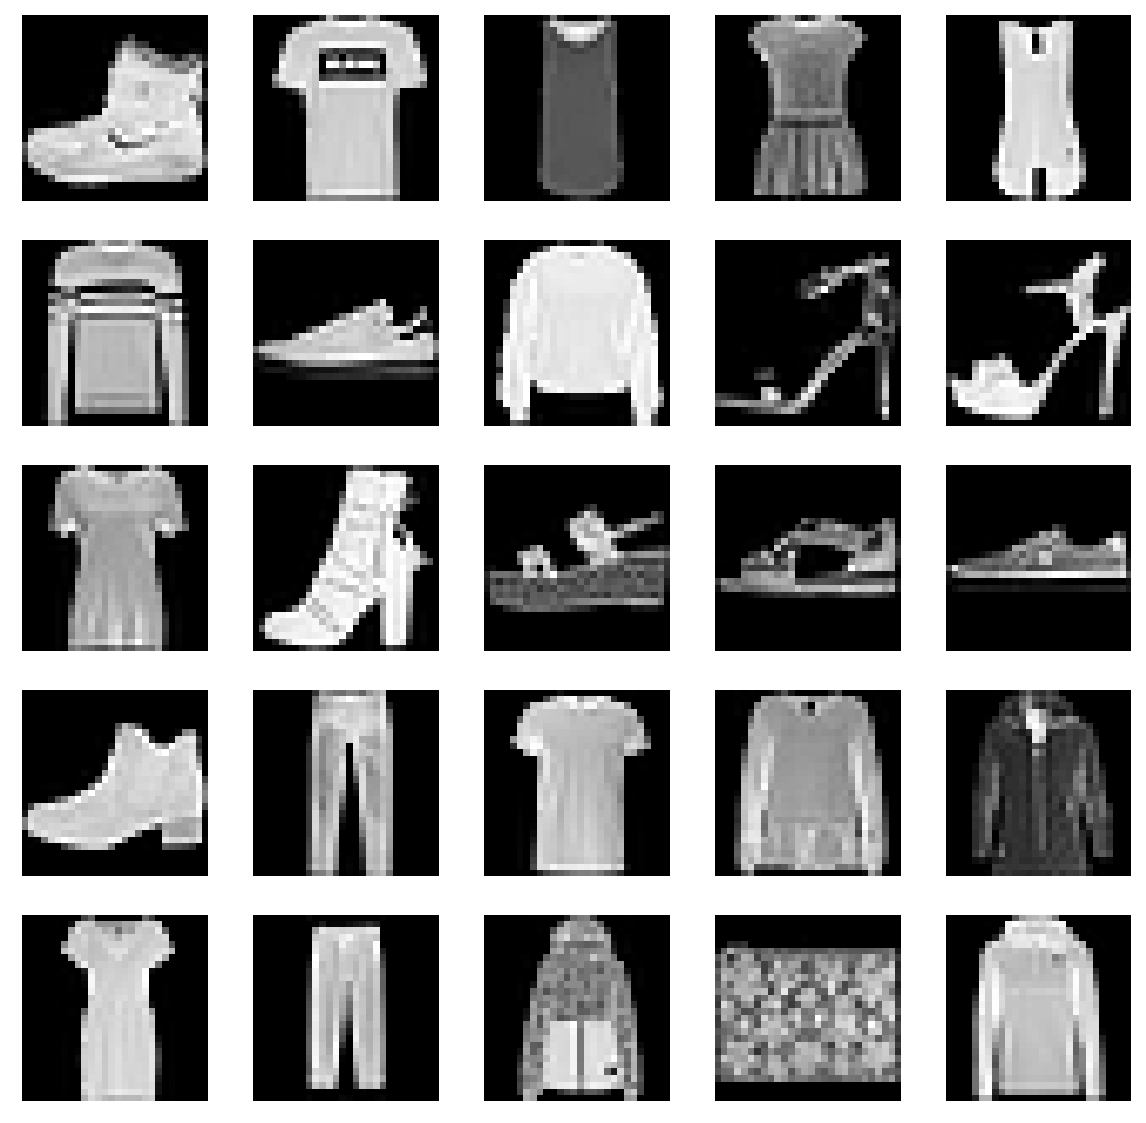

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_pics[i], cmap='gray')
plt.show()

Теперь приступим к выполнению д/з.

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [6]:
class RandomFourierFeatures:
    def __init__(self, n_features: int = 1000, size_for_sigma_squared: int = int(1e6), 
                 random_state: int = 10, require_PCA=True, new_dim: int = 50) -> None:
        self.n_features = n_features
        self.size_for_sigma_squared = size_for_sigma_squared
        self.random_state = random_state
        self.require_PCA = require_PCA
        self.new_dim = new_dim

        if self.require_PCA:
            self.PCA_model = PCA(n_components=self.new_dim)
        self.column_mean = None

        self.sigma_squared = None
        self.W_RFF = None
        self.b = None

    def get_sigma_squared(self, X: np.ndarray) -> float:
        """        
        Считает эвристическую оценку дисперсии.
        """
        # Генерируем индексы
        a = np.random.choice(len(X), size=self.size_for_sigma_squared)
        b = np.random.choice(len(X), size= self.size_for_sigma_squared)
    
        # Создаем пары объектов, пропуская пары с одинаковыми индексами (a[i] != b[i]) 
        # и убирая повторяющиеся пары кортежей (используем set)
        c = set([(a[i], b[i]) for i in range(self.size_for_sigma_squared) if a[i] != b[i]])
    
        # Считаем оценку
        sigma_squared = np.median([sum((X[i] - X[j])**2) for i, j in c])
        
        return sigma_squared

    def fit_transform(self, X: np.ndarray) -> np.ndarray: 
        """
        Использует предварительное понижение размерности исходного признакового пространства,
        если это указано.
        Далее делает отображение X в пространство R^n_features, где последнее является 
        аппроксимацией спремляющего пространства H. Следовательно, n_features — самые важные признаки из H.
        """
        # Понижаем размерность, если это требуется
        if self.require_PCA:
            # Считаем среднее для каждого столбца, или признака
            self.column_mean = X.mean(axis=0)
            # Центрируем данные так, что среднее в каждом столбце матрицы объект-признаки X равнялось нулю
            X_centered = X - self.column_mean
            # Понижаем размерность
            X = self.PCA_model.fit_transform(X_centered)

        # Находим эвристическую оценку дисперсии
        self.sigma_squared = self.get_sigma_squared(X)

        # Генерируем набор весов, не забывая, что np.random.normal берет в качестве инпута 
        # стандартное отклонение, а не дисперсию
        np.random.seed(self.random_state)
        self.W_RFF = np.random.normal(0, 1/np.sqrt(self.sigma_squared), size=(self.n_features, X.shape[1]))
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)

        # Формируем новые признаки посредством RFF
        X_expanded = np.cos(X @ self.W_RFF.T + self.b)

        # Возвращаем выборку с повышенной размерностью, а также веса для их дальнейшего применения к тестовой выборке
        return X_expanded
    
    def transform(self, X: np.ndarray) -> np.ndarray: 
        # Понижаем размерность, если это требуется
        if self.require_PCA:
            # Центрируем данные так, что среднее в каждом столбце матрицы объект-признаки X равнялось нулю
            X_centered = X - self.column_mean
            # Понижаем размерность
            X = self.PCA_model.transform(X_centered)

        X_expanded = np.cos(X @ self.W_RFF.T + self.b)

        return X_expanded

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin

class RFFPipeline(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, require_PCA: bool = True, new_dim: int = 50, n_features: int = 1000,
                 classifier: str = 'log_reg', random_state: int = 10) -> None:
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        PARAMETERS:
        require_PCA — whether to include PCA preprocessing.
        new_dim — PCA output size.
        n_features — amount of synthetic random features generated with RFF approximation.
        classifier — either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        """
        self.require_PCA = require_PCA
        self.new_dim = new_dim
        self.n_features = n_features
        self.classifier = classifier
        self.random_state = random_state

        # Не забываем, что мы учим на двойственной, а не прямой, задаче, а логистическая
        # регрессия по дефолту в sklearn учится на прямой задаче
        if self.classifier == 'log_reg':
            self.log_reg_classifier = LogisticRegression(dual=True, random_state=self.random_state, solver='liblinear')
        elif self.classifier == 'svm':
            # Делаем так, чтобы можно было реализовать predict_proba для линейного SVM
            self.svm_classifier = CalibratedClassifierCV(base_estimator=LinearSVC(dual=True, 
                                                                                  random_state=self.random_state), 
                                                         cv=5)
        else:
            raise ValueError(f"Classifier {self.classifier} is not defined here. Choose either 'log_reg' or 'svm'.")
        
        self.PCA_RFF_model = None

        self.W_RFF = None
        self.b_RFF = None

    def features_fit_transform(self, X: np.ndarray) -> np.ndarray:
        """
        Использование PCA и RFF на обучающей выборке.
        """
        self.PCA_RFF_model = RandomFourierFeatures(require_PCA=self.require_PCA, new_dim=self.new_dim, 
                                    n_features=self.n_features, random_state=self.random_state)
        X_expanded = self.PCA_RFF_model.fit_transform(X)

        return X_expanded

    def features_transform(self, X: np.ndarray) -> np.ndarray:
        """
        Использование PCA и RFF на тестовой выборке с уже фиксированными параметрами.
        """
        X_expanded = self.PCA_RFF_model.transform(X)

        return X_expanded

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set. 
        """
        X_tranformed = self.features_fit_transform(X)

        if self.classifier == 'log_reg':
            self.log_reg_classifier.fit(X_tranformed, y)
        else:
            self.svm_classifier.fit(X_tranformed, y)
        
        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Apply pipeline to obtain scores for input data.
        """
        X_tranformed = self.features_transform(X)

        if self.classifier == 'log_reg':
            y_pred_proba = self.log_reg_classifier.predict_proba(X_tranformed)
        else:
            y_pred_proba = self.svm_classifier.predict_proba(X_tranformed)
            
        return y_pred_proba

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_tranformed = self.features_transform(X)

        if self.classifier == 'log_reg':
            y_pred = self.log_reg_classifier.predict(X_tranformed)
        else:
            y_pred = self.svm_classifier.predict(X_tranformed)
            
        return y_pred

__Задание 2. (3 балла)__


In [8]:
def get_metrics(y_test: np.ndarray, y_pred: np.ndarray):
    print(f"Accuracy = {accuracy_score(y_test, y_pred):.4}")
    print(f"F_score_macro = {f1_score(y_test, y_pred, average='macro'):.4}")

</br>1. Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

__SVM со случайными признаками__

In [ ]:
np.random.seed(10)
svm_rff = RFFPipeline(classifier='svm')
start_time = time.time()
svm_rff.fit(X_train, y_train)
end_time = time.time()

Cкорость обучения:

In [ ]:
print(f'{((end_time - start_time) / 60):.3} minutes')

29.9 minutes


Метрики качества классификатора:

In [ ]:
start_time = time.time()
y_pred = svm_rff.predict(X_test)
end_time = time.time()

In [ ]:
get_metrics(y_test, y_pred)

Accuracy = 0.8798
F_score_macro = 0.8794


Cкорость применения модели:

In [ ]:
print(f'{((end_time - start_time) / 60):.3} minutes')

0.00965 minutes


__Линейный SVM на исходных признаках__

In [ ]:
np.random.seed(10)
svm_linear = LinearSVC()
start_time = time.time()
svm_linear.fit(X_train, y_train)
end_time = time.time()

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Cкорость обучения:

In [ ]:
print(f'{((end_time - start_time) / 60):.3} minutes')

6.67 minutes


Метрики качества классификатора:

In [ ]:
start_time = time.time()
y_pred = svm_linear.predict(X_test)
end_time = time.time()

In [ ]:
get_metrics(y_test, y_pred)

Accuracy = 0.7822
F_score_macro = 0.7772


Cкорость применения модели:

In [ ]:
print(f'{((end_time - start_time) / 60):.3} minutes')

0.000532 minutes


__Ядровой SVM на исходных признаках__

Поскольку ядровой SVM очень долго обучается, будем обучать его на случайном подмножестве объектов из обучающей выборки.

In [ ]:
np.random.seed(10)
idx = np.random.choice(np.arange(len(X_train)), size=int(2e4), replace=False)
svm_kernel = SVC(kernel='rbf')
start_time = time.time()
svm_kernel.fit(X_train[idx], y_train[idx])
end_time = time.time()

Cкорость обучения:

In [ ]:
print(f'{((end_time - start_time) / 60):.3} minutes')

1.97 minutes


Метрики качества классификатора:

In [ ]:
start_time = time.time()
y_pred = svm_kernel.predict(X_test)
end_time = time.time()

In [ ]:
get_metrics(y_test, y_pred)

Accuracy = 0.8668
F_score_macro = 0.8659


Cкорость применения модели:

In [ ]:
print(f'{((end_time - start_time) / 60):.3} minutes')

1.88 minutes


__Вывод__. 
- Как видим, идея со случайными признаками Фурье работает: признаки аппроксимируют гауссово ядро, добиваясь улучшения доли верых ответов на $12.5\%$ по сравнению с простым линейным SVM на исходных признаках. Тем не менее, линейный SVM над спремляющим пространством обучается около 30 минут, а линейный SVM над исходными признаками — около 7 минут. Однако время обучения не столь велико, чтобы затмить значительный рост метрики качества классификатора. 
-Кастательно ядрового SVM на исходных признаках — как было подмечено в задании, — можно сказать, что он _очень долго_ обучается на исходных признаках, поскольку ему необходимо хранить в памяти матрицу Грама, которая имеет размер $\ell \times \ell$. Следовательно, имеет смысл использовать линейный SVM со случайными признаками Фурье для аппроксимации ядрового SVM, доставая только самые важные признаки из спремляющего пространства. Тем самым, мы уменьшаем время обучения SVM на двойственной задаче и получаем похожее качество метрики как у SVM с гауссовым ядром.
- Время применения линейного SVM со случайными признаками и линейного SVM с исходными признаками невелико. Однако время применения ядрового SVM сопоставимо с его обучением из-за необходимости хранить матрицу Грама.

</br>2. Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.


Будем использовать `LightGBM` из-за его особенности в быстром построении композиции.


In [ ]:
from lightgbm import LGBMClassifier

__Градиентный бустинг на случайных признаках__

In [ ]:
RFF = RandomFourierFeatures(require_PCA=True, new_dim=50, n_features=1000, random_state=10)
X_expand_train = RFF.fit_transform(X_train)

Для начала подберем гиперпараметры для бустинга. Для этого создадим валидационную выборку, которая будет составлять $15\%$ от обучающей выборки.

In [ ]:
X_expand_train_, X_expand_val, y_train_, y_val = train_test_split(X_expand_train, y_train, 
                                                                test_size=0.15, random_state=10)

In [ ]:
X_expand_train_.shape, X_expand_val.shape

((51000, 1000), (9000, 1000))

In [ ]:
param_test_1 = {
 'max_depth': range(3, 15, 2),
 'num_leaves': range(21, 40, 2)
}

gsearch_1 = GridSearchCV(estimator=LGBMClassifier(objective='multiclass'), 
                         param_grid=param_test_1, scoring='accuracy', 
                         n_jobs=-1, cv=5, verbose=1)

gsearch_1.fit(X_expand_val, y_val)
gsearch_1.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 55.7min finished


{'max_depth': 13, 'num_leaves': 25}

In [ ]:
param_test_2 = {
 'learning_rate': [i/10 for i in range(0, 16)],
}

gsearch_2 = GridSearchCV(estimator=LGBMClassifier(objective='multiclass', max_depth=13, 
                                                  num_leaves=25), 
                         param_grid=param_test_2, scoring='accuracy', 
                         n_jobs=-1, cv=5, verbose=1)
gsearch_2.fit(X_expand_val, y_val)
gsearch_2.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  9.6min finished


{'learning_rate': 0.3}

In [ ]:
param_test_3 = {
 'n_estimators': range(90, 210, 10)
}

gsearch_3 = GridSearchCV(estimator=LGBMClassifier(objective='multiclass', max_depth=13,
                                                  num_leaves=25, learning_rate=0.3), 
                         param_grid=param_test_3, scoring='accuracy', 
                         n_jobs=-1, cv=5, verbose=1)
gsearch_3.fit(X_expand_val, y_val)
gsearch_3.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  60 | elapsed: 13.6min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 14.6min finished


{'n_estimators': 170}

Теперь обучим наш классификатор на оптимальных гиперпараметрах.

In [ ]:
np.random.seed(10)
lightgbm_classifier = LGBMClassifier(objective='multiclass', max_depth=13,
                                     num_leaves=25, learning_rate=0.3, n_estimators=170)
start_time = time.time()
lightgbm_classifier.fit(X_expand_train_, y_train_)
end_time = time.time()

Cкорость обучения:

In [ ]:
print(f'{((end_time - start_time) / 60):.3} minutes')

2.47 minutes


Метрики качества классификатора:

In [ ]:
X_expand_test = RFF.transform(X_test)

In [ ]:
start_time = time.time()
y_pred = lightgbm_classifier.predict(X_expand_test)
end_time = time.time()

In [ ]:
get_metrics(y_test, y_pred)

Accuracy = 0.8737
F_score_macro = 0.8738


Cкорость применения модели:

In [ ]:
print(f'{((end_time - start_time) / 60):.3} minutes')

0.00162 minutes


__Градиентный бустинг на исходных признаках__

Снова подберем гиперпараметры.

In [ ]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=10)

In [ ]:
param_test_1 = {
 'max_depth': range(3, 15, 2),
 'num_leaves': range(21, 40, 2)
}

gsearch_1 = GridSearchCV(estimator=LGBMClassifier(objective='multiclass'), 
                         param_grid=param_test_1, scoring='accuracy',
                         n_jobs=-1, cv=5, verbose=1)

gsearch_1.fit(X_val, y_val)
gsearch_1.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 28.6min finished


{'max_depth': 13, 'num_leaves': 39}

In [ ]:
param_test_2 = {
 'learning_rate': [i/10 for i in range(0, 16)],
}

gsearch_2 = GridSearchCV(estimator=LGBMClassifier(objective='multiclass', max_depth=13, 
                                                  num_leaves=39), 
                         param_grid=param_test_2, scoring='accuracy', 
                         n_jobs=-1, cv=5, verbose=1)
gsearch_2.fit(X_val, y_val)
gsearch_2.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.2min finished


{'learning_rate': 0.3}

In [ ]:
param_test_3 = {
 'n_estimators': range(90, 210, 10)
}

gsearch_3 = GridSearchCV(estimator=LGBMClassifier(objective='multiclass', max_depth=13, 
                                                  num_leaves=39, learning_rate=0.3), 
                         param_grid=param_test_3, scoring='accuracy', 
                         n_jobs=-1, cv=5, verbose=1)
gsearch_3.fit(X_val, y_val)
gsearch_3.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  60 | elapsed:  7.7min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.1min finished


{'n_estimators': 130}

Обучим наш классификатор.

In [ ]:
np.random.seed(10)
lightgbm_classifier = LGBMClassifier(objective='multiclass', max_depth=13, num_leaves=39, 
                                     learning_rate=0.3, n_estimators=130)
start_time = time.time()
lightgbm_classifier.fit(X_train_, y_train_)
end_time = time.time()

Cкорость обучения:

In [ ]:
print(f'{((end_time - start_time) / 60):.3} minutes')

0.586 minutes


Метрики качества классификатора:

In [ ]:
start_time = time.time()
y_pred = lightgbm_classifier.predict(X_test)
end_time = time.time()

In [ ]:
get_metrics(y_test, y_pred)

Accuracy = 0.8992
F_score_macro = 0.899


Cкорость применения модели:

In [ ]:
print(f'{((end_time - start_time) / 60):.3} minutes')

0.00114 minutes


__Вывод__. Для градиентного спуска генерация случайных признаков Фурье не имеет смысла и даже немного ухудшает качество классификатора. Действительно, градиентный бустинг умеет находить нелинейные зависимости в данных, и поэтому не нуждается в спремлении пространства. Так же стоит отметить быстрое обучение модели: градиентному бустингу не надо хранить в памяти матрицу Грама. Также у бустинга достаточно высокая доля верных ответов на тестовой выборке. Все это подтверждает доводы от том, что сейчас лучшим подходом к построению нелинейных моделей является градиентный бустинг, а не добавление новых признаков к исходному набору факторов линейной модели.

__Задание 3. (2 балла)__

<br/>1. Помогает ли предварительное понижение размерности с помощью PCA? 

Проверим, помогает ли предварительное понижение размерности с помощью PCA на линейном SVM, обучающемуся на случайных признаках. Для сокращения времени обучения будем использовать случайную подвыборку.

In [11]:
np.random.seed(10)
idx = np.random.choice(np.arange(len(X_train)), size=20000, replace=False)

In [9]:
n_dims = [784] + list(range(50, 800, 50)[::-1])

In [ ]:
accuracy = []

np.random.seed(10)  

for n_dim in tqdm(n_dims):
    if n_dim == 784:
        svm_rff = RFFPipeline(classifier='svm', require_PCA=False)
        svm_rff.fit(X_train[idx], y_train[idx])
        y_pred = svm_rff.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
    else:
        svm_rff = RFFPipeline(classifier='svm', require_PCA=True, new_dim=n_dim)
        svm_rff.fit(X_train[idx], y_train[idx])
        y_pred = svm_rff.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))

Качество без предварительного понижения пространства посредством PCA:

In [11]:
accuracy[0]

0.1065

Посмотрим, как качество зависит от предварительного понижения пространства:

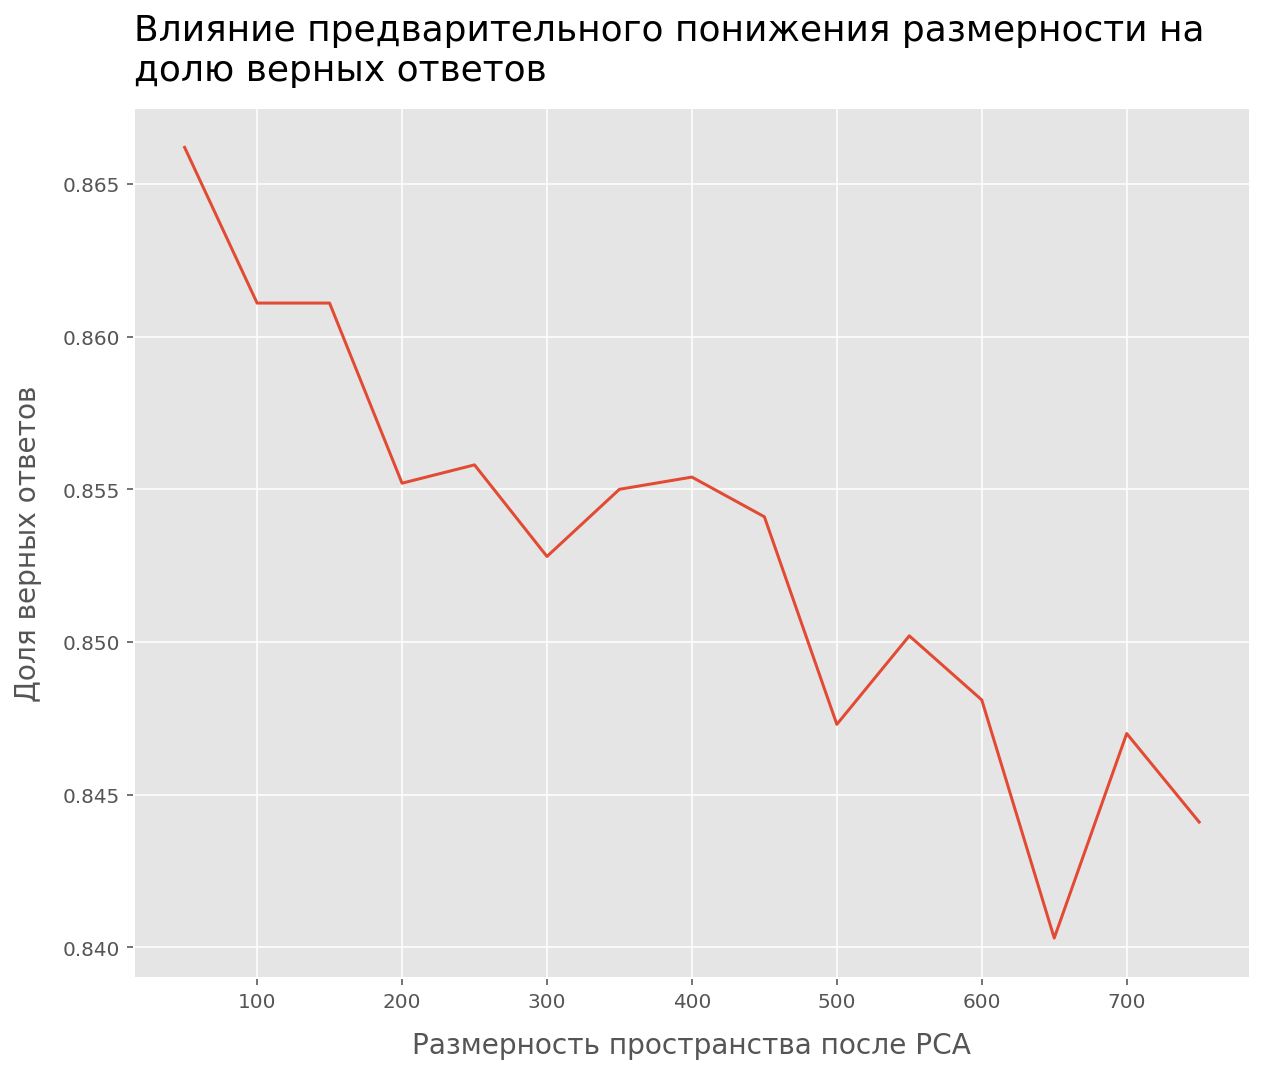

In [43]:
plt.title('Влияние предварительного понижения размерности на \nдолю верных ответов', pad=14, fontsize=18, loc='left')
plt.xlabel('Размерность пространства после PCA', labelpad=10, fontsize=14)
plt.ylabel('Доля верных ответов', labelpad=10, fontsize=14)

plt.plot(n_dims[1:], accuracy[1:]);

__Вывод__. Доля верных ответов без предварительного понижения пространства посредством PCA очень низка — $10.65\%$, что соответствует рандомному выбору ответа на 10 представленных классах. Можно заметить, что у исходного признакового описания объекта, картинки размера $28 \times 28$, много нулей, которые не несут какую-либо информацию. Очень часто нули находятся во всей строке объекта $x_i$, то есть по краям картинки. Поэтому, если сразу применить $X^{\ell}W^{T}_{\text{RFF}}$, то у нас выйдут почти нулевые значения, которые также не будут нести в себе мало информации. Однако при небольшом уменьшении пространства метрика качества увеличивается в 8 раз. И при дальнейшем понижении размерности мы видим отрицательную зависимость между долей верных ответов и размерностью исходного признакового описания перед использованием RFF. 

<br/>2. Как зависит итоговое качество от `n_features`? Выходит ли оно на плато при росте `n_features`?

Как видим, лучшее качество достигается при `new_dim` = 50 — зафиксируем данное значение гиперпараметра. И теперь посмотрим, как доля верных ответов зависит от `n_features` при использовнии RFF.

In [ ]:
accuracy_svm = []
time_to_learn_svm = []
n_features = list(range(100, 2000, 50))

np.random.seed(10)
for n in tqdm(n_features):  
    svm_rff = RFFPipeline(classifier='svm', require_PCA=True, new_dim=50, 
                          n_features=n)
    
    start_time = time.time()
    svm_rff.fit(X_train[idx], y_train[idx])
    end_time = time.time()
    time_to_learn_svm.append((end_time - start_time) / 60)

    y_pred = svm_rff.predict(X_test)
    accuracy_svm.append(accuracy_score(y_test, y_pred))

In [ ]:
accuracy_log_reg = []
time_to_learn_log_reg = []

np.random.seed(10)  

for n in tqdm(n_features):
    log_reg_rff = RFFPipeline(classifier='log_reg', require_PCA=True, new_dim=50, 
                              n_features=n)
    
    start_time = time.time()
    log_reg_rff.fit(X_train[idx], y_train[idx])
    end_time = time.time()
    time_to_learn_log_reg.append((end_time - start_time) / 60)
    
    y_pred = log_reg_rff.predict(X_test)
    accuracy_log_reg.append(accuracy_score(y_test, y_pred))

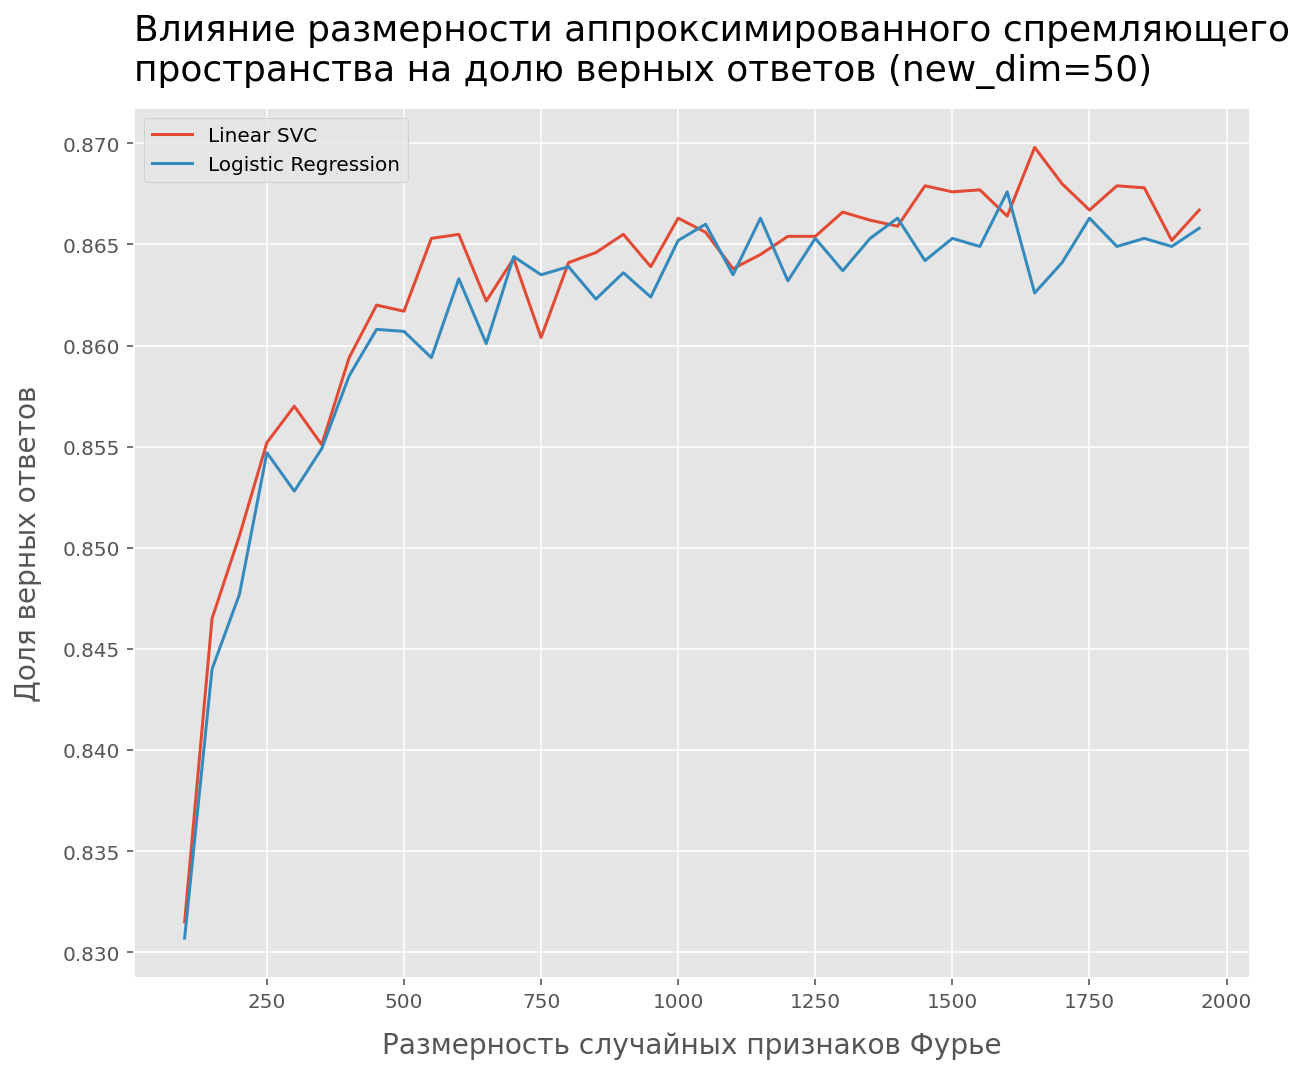

In [21]:
plt.title('Влияние размерности аппроксимированного спремляющего \nпространства на долю верных ответов (new_dim=50)', pad=14, fontsize=18, loc='left')
plt.xlabel('Размерность случайных признаков Фурье', labelpad=10, fontsize=14)
plt.ylabel('Доля верных ответов', labelpad=10, fontsize=14)

plt.plot(n_features, accuracy_svm, label='Linear SVC')
plt.plot(n_features, accuracy_log_reg, label='Logistic Regression')

plt.legend();

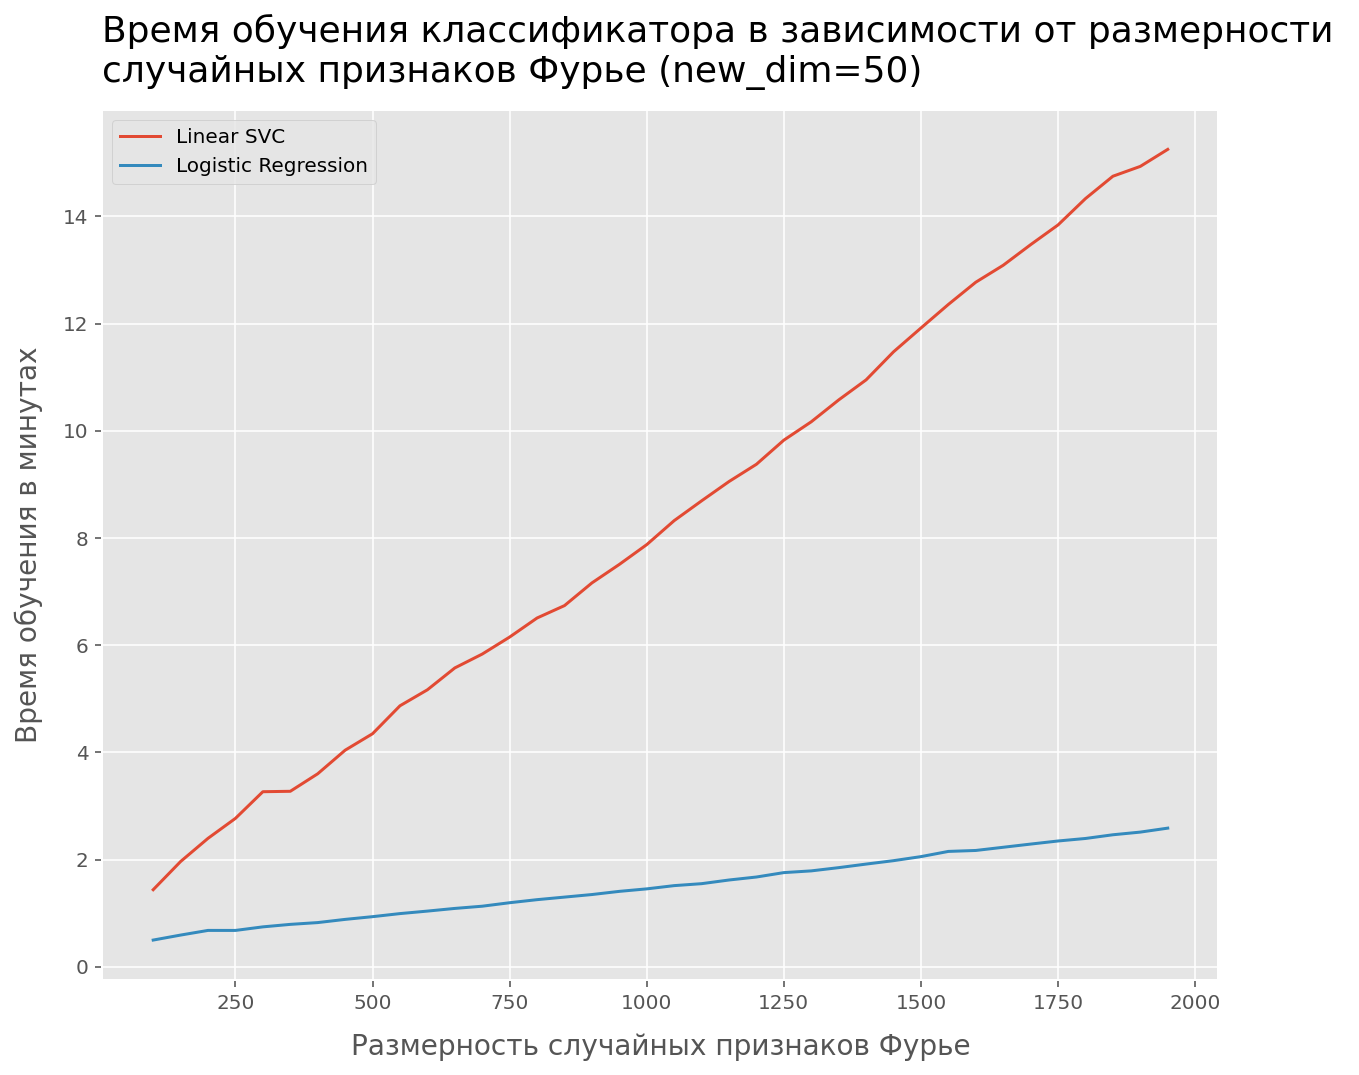

In [22]:
plt.title('Время обучения классификатора в зависимости от размерности \nслучайных признаков Фурье (new_dim=50)', pad=14, fontsize=18, loc='left')
plt.xlabel('Размерность случайных признаков Фурье', labelpad=10, fontsize=14)
plt.ylabel('Время обучения в минутах', labelpad=10, fontsize=14)

plt.plot(n_features, time_to_learn_svm, label='Linear SVC')
plt.plot(n_features, time_to_learn_log_reg, label='Logistic Regression')

plt.legend();

__Вывод__. Итоговое качество для как линейного SVM, так и логистической регрессии действительно выходит на плато при увелечении размерности случайных признаков Фурье — `n_features`. В предоставленной ниже статье, в бонусной части, говорится, что `n_features` берут достаточно большим, дабы уменшить ошибку аппроксимации гауссового ядра, что логично. Чем больше размерность случайных признаков Фурье, тем меньше наша ошибка и тем итоговое качество больше похоже на качество при использовании гауссового ядра, все меньше и меньше отклоняясь от данного значения.

<br/>3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

__Вывод__. Как видим на двух графиках выше — при фиксированном исходном признаковом описании `new_dim=50` перед применением RFF, —  оба классификатора на случайных признаках при решении двойственной задачи дают примерно одинаковые результаты. Время обучения как линейного SVM, так и логистической регрессии растет линейно с увеличением размерности случайных признаков `n_features`. Однако, логистическая регрессия имеет меньший наклон и обучается быстрее. Следовательно, в нашей задаче предпочтительнее использовать логистическую регрессию.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

В статье говорится, что матрица весов может быть представлена в виде:

$W_{\text{RFF}} = \dfrac{1}{\sigma}G$, где $G$ — гауссова матрица $d \times d$.

В то же время авторы задают следующую ортогональную матрицу:

$W_{\text{ORF}} = \dfrac{1}{\sigma}SQ$, где $S$ — диагональная матрица, в которой элементы распределены по $\chi^2(d)$, $Q$ — равномерно распределенная ортогональная матрица, полученная посредством QR декомпозиции гаусовой матрицы $G$.

In [27]:
class OrthogonalRandomFeatures:
    def __init__(self, n_features: int = 1000, size_for_sigma_squared: int = int(1e6), 
                 random_state: int = 10, require_PCA=True, new_dim: int = 50) -> None:
        self.n_features = n_features
        self.size_for_sigma_squared = size_for_sigma_squared
        self.random_state = random_state
        self.require_PCA = require_PCA
        self.new_dim = new_dim

        if self.require_PCA:
            self.PCA_model = PCA(n_components=self.new_dim)
        self.column_mean = None

        self.W_ORF = []
        self.b = None

    def get_sigma_squared(self, X: np.ndarray) -> float:
        """        
        Считает эвристическую оценку дисперсии.
        """
        # Генерируем индексы
        a = np.random.choice(len(X), size=self.size_for_sigma_squared)
        b = np.random.choice(len(X), size= self.size_for_sigma_squared)
    
        # Создаем пары объектов, пропуская пары с одинаковыми индексами (a[i] != b[i]) 
        # и убирая повторяющиеся пары кортежей (используем set)
        c = set([(a[i], b[i]) for i in range(self.size_for_sigma_squared) if a[i] != b[i]])
    
        # Считаем оценку
        sigma_squared = np.median([sum((X[i] - X[j])**2) for i, j in c])
        
        return sigma_squared

    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        # Понижаем размерность, если это требуется
        if self.require_PCA:
            # Считаем среднее для каждого столбца, или признака
            self.column_mean = X.mean(axis=0)
            # Центрируем данные так, что среднее в каждом столбце матрицы объект-признаки X равнялось нулю
            X_centered = X - self.column_mean
            # Понижаем размерность
            X = self.PCA_model.fit_transform(X_centered)

        # Находим эвристическую оценку дисперсии
        sigma_squared = self.get_sigma_squared(X)

        self.W_ORF = []
        
        n_stacks = ((self.n_features - 1) // self.new_dim) + 1
        
        for _ in range(n_stacks):
            # Находим гауссову матрицу G 
            G = np.random.normal(0, 1, size=(self.new_dim, self.new_dim))
            # Проводим QR декомпозицию
            Q, r = np.linalg.qr(G)
            # Находим S
            S = np.diag(sts.chi.rvs(df=self.new_dim, size=self.new_dim))
            # Находим W_ORF
            self.W_ORF.append(1/np.sqrt(sigma_squared) * (S @ Q))

        # Нам нужно только n_features, а не больше
        self.W_ORF = np.vstack(self.W_ORF)[:self.n_features, :self.new_dim]
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)

        # Генерируем рандомные признаки посредством ORF
        X_expanded = np.cos(X @ self.W_ORF.T + self.b)
        return X_expanded

    def transform(self, X: np.ndarray) -> np.ndarray: 
        # Понижаем размерность, если это требуется
        if self.require_PCA:
            # Центрируем данные так, что среднее в каждом столбце матрицы объект-признаки X равнялось нулю
            X_centered = X - self.column_mean
            # Понижаем размерность
            X = self.PCA_model.transform(X_centered)

        # Генерируем рандомные признаки посредством ORF
        X_expanded = np.cos(X @ self.W_ORF.T + self.b)
        return X_expanded

Сравним RFF и ORF на линейном SVM по случайной подвыборке для экономии времени. 

In [48]:
np.random.seed(10)
idx = np.random.choice(np.arange(len(X_train)), size=int(2e4), replace=False)
X_train_, y_train_ = X_train[idx], y_train[idx]

In [49]:
n_features = list(range(100, 1400, 50))

In [ ]:
accuracy_score_rff = []
time_to_fit_transform_rff = []
time_to_transform_rff = []

np.random.seed(10)
for n in tqdm(n_features):
    RFF = RandomFourierFeatures(n_features=n)
    start_time = time.time()
    X_train_expand = RFF.fit_transform(X_train_)
    end_time = time.time()
    time_to_fit_transform_rff.append((end_time - start_time) / 60)

    start_time = time.time()
    X_test_expand = RFF.transform(X_test)
    end_time = time.time()
    time_to_transform_rff.append((end_time - start_time) / 60)

    linear_svm = LinearSVC()
    linear_svm.fit(X_train_expand, y_train_)
    y_pred = linear_svm.predict(X_test_expand)
    accuracy_score_rff.append(accuracy_score(y_test, y_pred))

In [ ]:
accuracy_score_orf = []
time_to_fit_transform_orf = []
time_to_transform_orf = []

np.random.seed(10)
for n in tqdm(n_features):
    ORF = OrthogonalRandomFeatures(n_features=n)
    start_time = time.time()
    X_train_expand = ORF.fit_transform(X_train_)
    end_time = time.time()
    time_to_fit_transform_orf.append((end_time - start_time) / 60)

    start_time = time.time()
    X_test_expand = ORF.transform(X_test)
    end_time = time.time()
    time_to_transform_orf.append((end_time - start_time) / 60)

    linear_svm = LinearSVC()
    linear_svm.fit(X_train_expand, y_train_)
    y_pred = linear_svm.predict(X_test_expand)
    accuracy_score_orf.append(accuracy_score(y_test, y_pred))

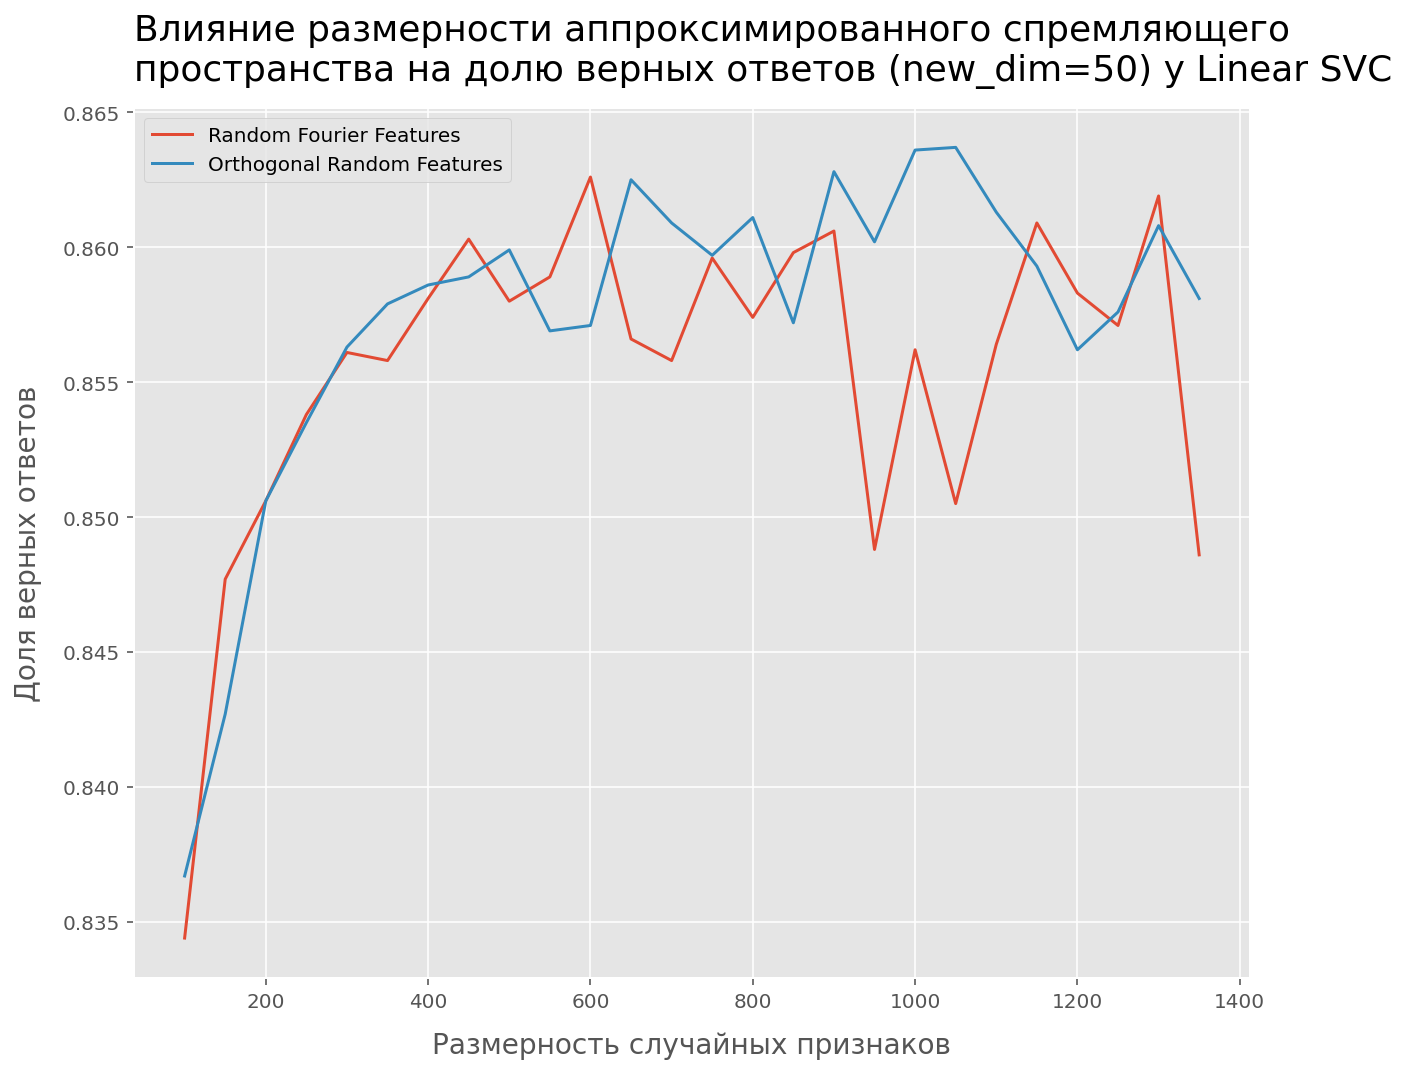

In [40]:
plt.title('Влияние размерности аппроксимированного спремляющего \nпространства на долю верных ответов (new_dim=50) у Linear SVC', pad=14, fontsize=18, loc='left')
plt.xlabel('Размерность случайных признаков', labelpad=10, fontsize=14)
plt.ylabel('Доля верных ответов', labelpad=10, fontsize=14)

plt.plot(n_features, accuracy_score_rff, label='Random Fourier Features')
plt.plot(n_features, accuracy_score_orf, label='Orthogonal Random Features')

plt.legend();

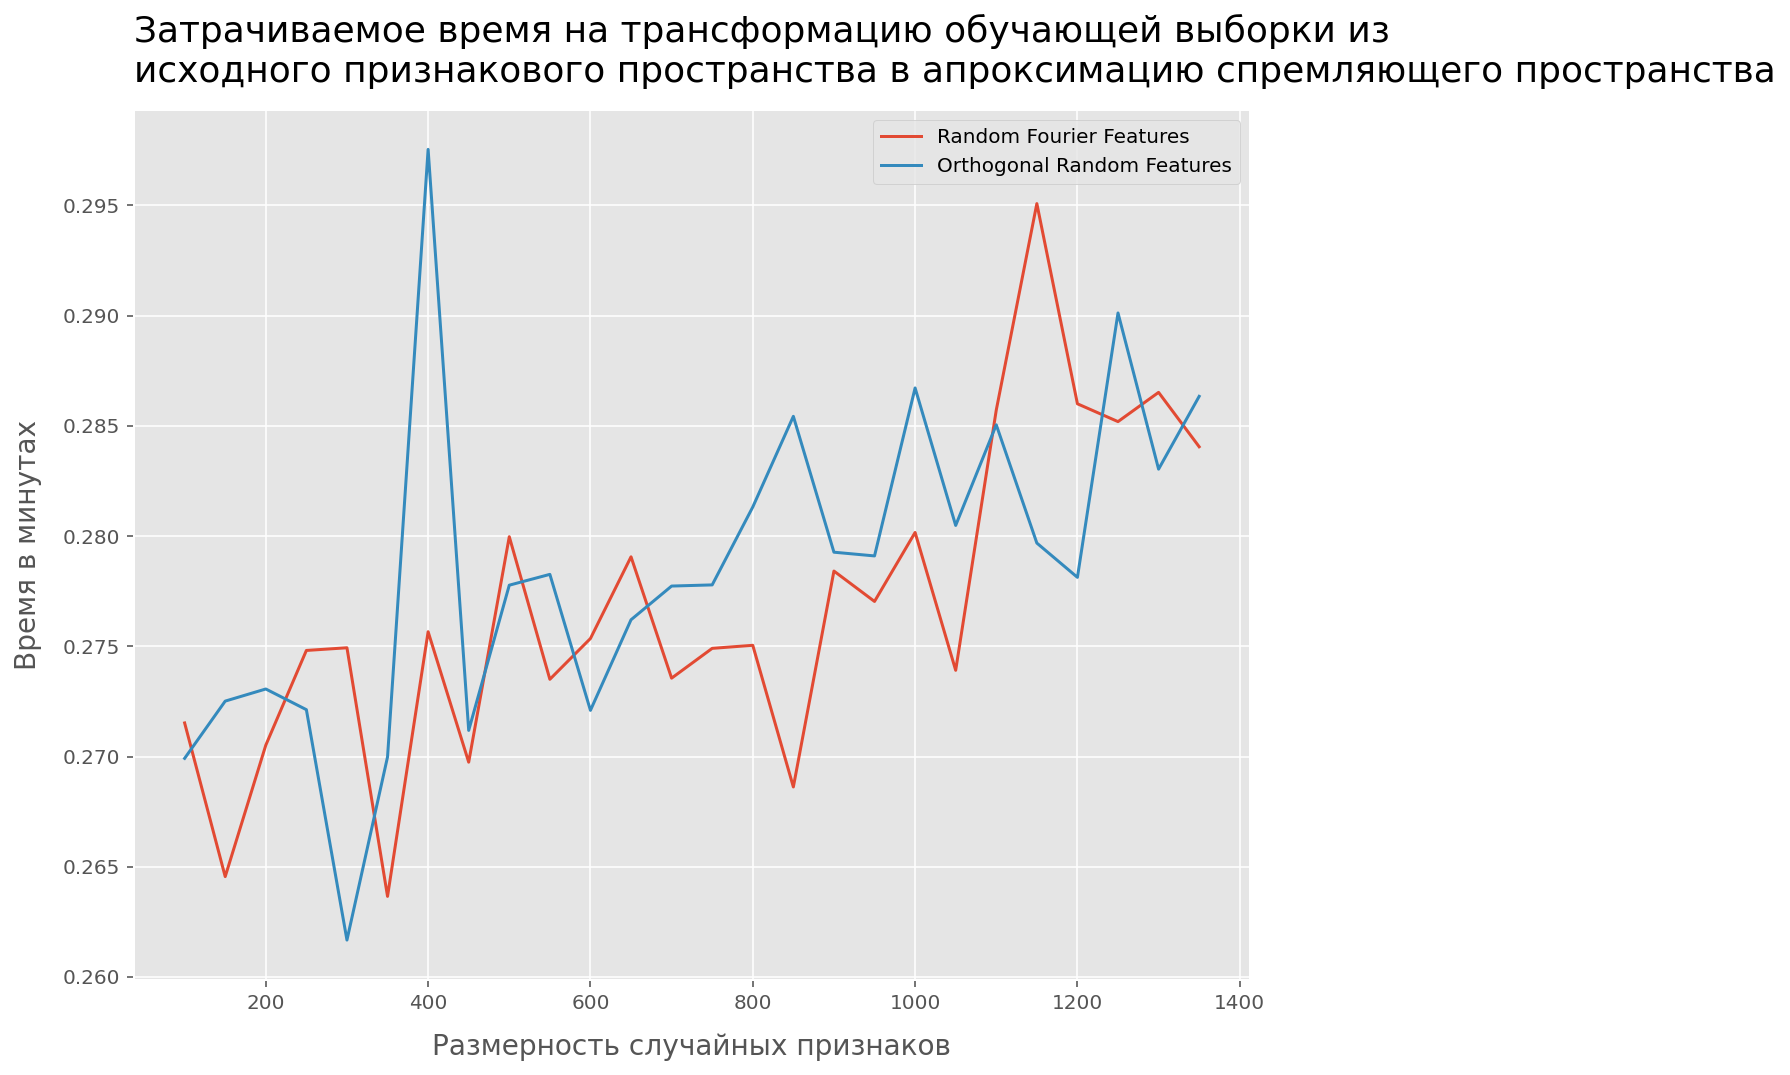

In [47]:
plt.title('Затрачиваемое время на трансформацию обучающей выборки из \nисходного признакового пространства в апроксимацию спремляющего пространства', pad=14, fontsize=18, loc='left')
plt.xlabel('Размерность случайных признаков', labelpad=10, fontsize=14)
plt.ylabel('Время в минутах', labelpad=10, fontsize=14)

plt.plot(n_features, time_to_fit_transform_rff, label='Random Fourier Features')
plt.plot(n_features, time_to_fit_transform_orf, label='Orthogonal Random Features')

plt.legend();

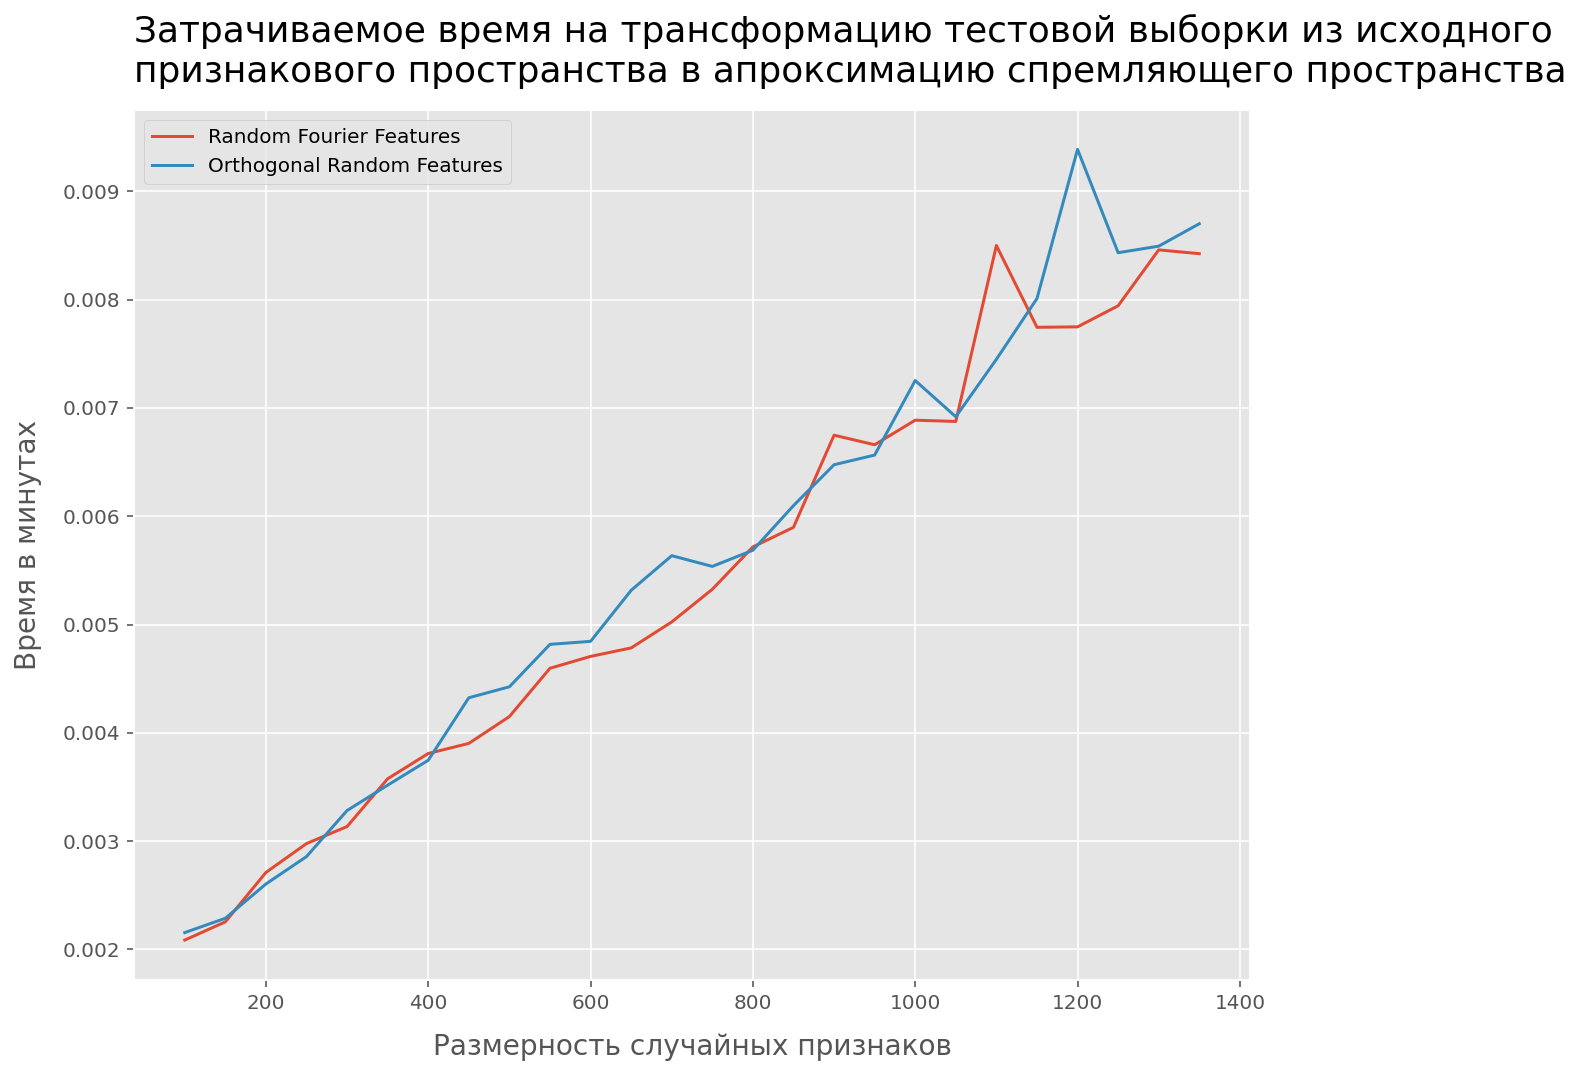

In [56]:
plt.title('Затрачиваемое время на трансформацию тестовой выборки из исходного \nпризнакового пространства в апроксимацию спремляющего пространства', pad=14, fontsize=18, loc='left')
plt.xlabel('Размерность случайных признаков', labelpad=10, fontsize=14)
plt.ylabel('Время в минутах', labelpad=10, fontsize=14)

plt.plot(n_features, time_to_transform_rff[:26], label='Random Fourier Features')
plt.plot(n_features, time_to_transform_orf, label='Orthogonal Random Features')

plt.legend();

__Вывод__. В среднем можно сказать, что ORF лучше RFF, если сравнивать по доле ответов. Касательно времени на исполнение ORF и RFF оба имеют сложность $O(\text{n_features} \times \text{new_dim})$ и примерно одинаковы по времени исполнения, что представлено на последнем графике. Однако, чтобы изначально получить дефолтные веса, при `n_features` > `new_dim` ORF в среднем нужно немного больше времени вследствие своей реализации: генерирует `n_features - 1 // new_dim + 1` независимых матриц, а потом соединяет их.

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.